# 🎲 Stock Sentiment Analysis

This notebook performs sentiment analysis on stock-related comments and compares the sentiment scores with stock price data. It uses a pre-trained BERT model fine-tuned for financial sentiment analysis to classify comments as positive, neutral, or negative.

### Import Libraries

We start by importing necessary libraries for data handling, model loading, and visualization.


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader

from tqdm.notebook import trange, tqdm
from matplotlib.dates import date2num
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import copy
import numpy as np
from datetime import datetime
import os
import zipfile
import random

from transformers import BertForSequenceClassification, AutoTokenizer, pipeline, BertTokenizer

### Load Pre-trained Sentiment Model

Loads a BERT model fine-tuned on financial tweets to classify sentiment. The model is set to evaluation mode to ensure it doesn't update weights during inference.

In [4]:
# We'll use a model that was specifically fine-tuned on online social media comments around finance!
model = BertForSequenceClassification.from_pretrained(
    "StephanAkkerman/FinTwitBERT-sentiment",
    num_labels=3,
    id2label={0: "neutral", 1: "positive", 2: "negative"},
    label2id={"neutral": 0, "positive": 1, "negative": 2},
)
model.eval()

tokenizer = AutoTokenizer.from_pretrained(
    "StephanAkkerman/FinTwitBERT-sentiment"
)

# Construct a Huggingface pipeline!
sentiment_classifier = pipeline(
    "text-classification", model=model, tokenizer=tokenizer, device=1, 
    top_k=None, padding=True, truncation=True, max_length=256
)

Device set to use mps:1


### Dataset and DataLoader

Define a custom dataset class to handle text data stored in files. The class ensures data is unzipped and provides methods to access individual data samples.

In [5]:
class MyTextDataset(Dataset):
    def __init__(self, root_data_dir, stock_code):
        self.root_data_dir = root_data_dir
        self.stock_code = stock_code

        # Ensure the data is unzipped
        self.check_and_unzip()
        
        self.data_dir = os.path.join(self.root_data_dir, self.stock_code)
        
        # Get the list of files in the unzipped directory
        self.file_list = os.listdir(self.data_dir)
        self.num_samples = len(self.file_list)

    def check_and_unzip(self):
        # Specify the file name to search for
        zip_file_name = self.stock_code + ".zip"
        zip_path = os.path.join(self.root_data_dir, zip_file_name)
        extracted_dir = os.path.join(self.root_data_dir, self.stock_code)

        # Check if the extracted directory already exists
        if not os.path.exists(extracted_dir):
            # Check if the .zip file exists in the specified directory
            if os.path.exists(zip_path):
                # Unzip the file
                with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                    zip_ref.extractall(self.root_data_dir)
                print(f"Extracted {zip_file_name} to {self.root_data_dir}")
            else:
                print(f"{zip_file_name} not found in {self.root_data_dir}")
        else:
            print(f"Directory {extracted_dir} already exists, skipping extraction.")

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.file_list[idx])
        with open(file_path, 'r', encoding='utf-8') as file:
            raw_data = file.read()
            
        text_data = raw_data.split(" : ")[-1]
        time_data = raw_data.split(" : ")[0]
            
        return text_data, time_data

### Load and Prepare Data

Instantiate the dataset and dataloader to prepare batches of data for sentiment analysis.

In [6]:
stock_code = "nab"

# Example usage:
root_data_dir = "/Users/botcoder/MyDocs/CBL/Commodity Trading & Risk Management/project/commodity-trading-assistant/test_data"
dataset = MyTextDataset(root_data_dir, stock_code)

loader = DataLoader(dataset, batch_size=32)

Directory /Users/botcoder/MyDocs/CBL/Commodity Trading & Risk Management/project/commodity-trading-assistant/test_data/nab already exists, skipping extraction.


### Sentiment Prediction

Use the sentiment analysis pipeline to predict the sentiment of each comment. The results are logged for further analysis.

In [9]:
log_positive_score = []
log_neutral_score = []
log_negative_score = []
log_datetime = []

for (input_data, time_data) in tqdm(loader):
    with torch.amp.autocast('cuda'):
        outputs = sentiment_classifier(list(input_data), batch_size=len(input_data))

    for (output, td) in zip(outputs, time_data):
        for label in output:
            if label["label"] == 'positive':
                log_positive_score.append(label["score"])
            elif label["label"] == 'neutral':
                log_neutral_score.append(label["score"])
            elif label["label"] == 'negative':
                log_negative_score.append(label["score"])

        log_datetime.append(td)

  0%|          | 0/531 [00:00<?, ?it/s]

/Users/botcoder/MyDocs/CBL/Commodity Trading & Risk Management/project/commodity-trading-assistant/.venv/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


## Organize Sentiment Data

We organize the sentiment scores into a pandas DataFrame, indexed by datetime, and sort the data for time series analysis.

In [11]:
# Create a panda dataframe
df = pd.DataFrame({
    'Datetime': log_datetime,
    'positive': log_positive_score,
    'neutral': log_neutral_score,
    'negative': log_negative_score,

})
# Set index to the date time
df['Datetime'] = pd.to_datetime(df['Datetime'], utc=True)

# Sort all rows by the datetimeindex
df.set_index('Datetime', inplace=True)
df.sort_index(inplace=True)

## Calculate Sentiment Score

Calculate a sentiment score based on positive and negative predictions and compute daily median sentiment scores.

In [12]:
# Calculate a 'score' using the positive and negative predictions
df['score'] = (df['positive'] - df['negative'])/(df['positive'] + df['negative'])

# Calculate median sentiment for everyday
df_daily = df.resample('D').median()
df_daily.fillna(0, inplace=True)

# Count the number of entries per day
df_daily_count = df.resample('D').size()

# If you want to add this count to your existing df_daily DataFrame:
df_daily['entry_count'] = df_daily_count
df_daily['entry_count_ma'] = df_daily['entry_count'].rolling(window=28, center=False).mean()

# Calculate a 28 day moving average of the score
df_daily['score_ma'] = df_daily['score'].rolling(window=28, center=False).mean()

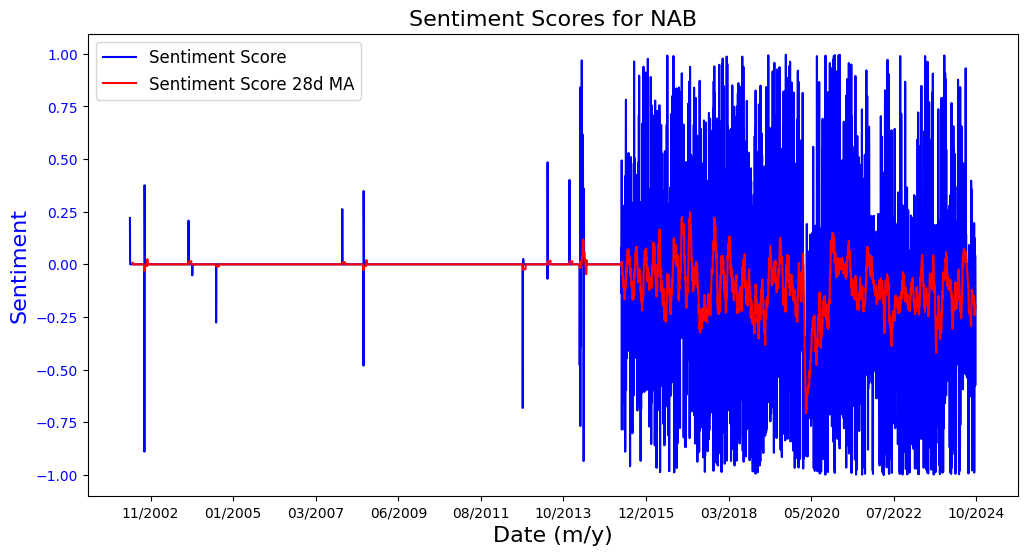

In [13]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the sentiment score on the first y-axis
ax1.plot(df_daily.index, 
         df_daily['score'], color='blue', label='Sentiment Score')

ax1.plot(df_daily.index, 
         df_daily['score_ma'], color='red', label='Sentiment Score 28d MA')

ax1.set_xlabel('Date (m/y)', fontsize=16)
ax1.set_ylabel('Sentiment', color='blue', fontsize=16)
ax1.tick_params(axis='y', labelcolor='blue')

# Increase the number of x-axis ticks
ax1.xaxis.set_major_locator(plt.MaxNLocator(12))
ax1.xaxis.set_major_formatter(DateFormatter('%m/%Y'))

ax1.legend(loc='upper left', fontsize=12)

_ = plt.title('Sentiment Scores for ' + stock_code.upper(), fontsize=16)

### Get Stock Price Data

Download and process stock price data using YahooFinance API to compare with sentiment scores. Calculate moving averages and detrended prices for analysis.

In [14]:
# Download the stock price data to compare
msft = yf.Ticker(stock_code + ".ax")
stock_data = msft.history(period = "9y", interval = "1d")
stock_data.drop('Dividends', axis=1, inplace=True)
stock_data.drop('Stock Splits', axis=1, inplace=True)

# Get a price for every day (including weekends etc)
stock_data = stock_data.resample('D').mean()

# Fill forward price data (carry the price data forward for weekends etc)
stock_data.fillna(method='ffill', inplace=True)

# Get a 28 day and 120 day moving average of the close price
stock_data['close_ma'] = stock_data['Close'].rolling(window=28, center=False).mean()
stock_data['close_120_ma'] = stock_data['Close'].rolling(window=120, center=False).mean()
stock_data.dropna(inplace=True)

# Calculate the short term price movements by subtracting the 120 day MA
stock_data['close_diff'] = stock_data['Close'] - stock_data['close_120_ma']

/var/folders/1k/8slkzd357lj7270s470tsybw0000gn/T/ipykernel_62809/222914016.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data.fillna(method='ffill', inplace=True)


In [20]:
# Cut the sentiment data to match the same time period as the stock price data
specific_date = stock_data.index[0]

# Filter the DataFrame to get data after the specific date
df_after_specific_date = df_daily.loc[specific_date:]

### Plot Sentiment with Stock Data

Plots to visualize the relationship between sentiment scores and stock prices over time.

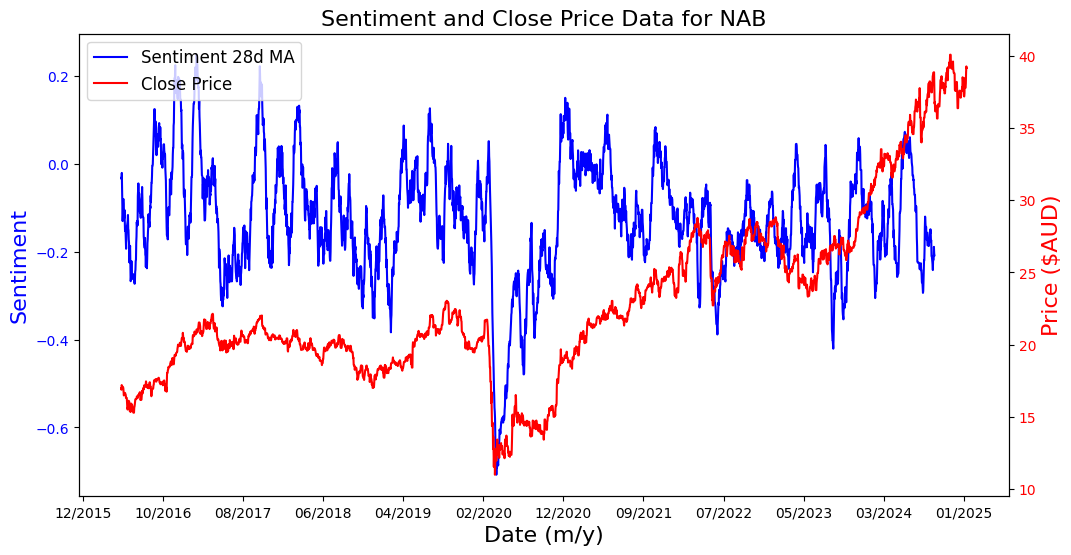

In [21]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the sentiment score on the first y-axis
ax1.plot(df_after_specific_date.index, 
         df_after_specific_date['score_ma'], color='blue', label='Sentiment 28d MA')

ax1.set_xlabel('Date (m/y)', fontsize=16)
ax1.set_ylabel('Sentiment', color='blue', fontsize=16)
ax1.tick_params(axis='y', labelcolor='blue')

# Increase the number of x-axis ticks
ax1.xaxis.set_major_locator(plt.MaxNLocator(12))
ax1.xaxis.set_major_formatter(DateFormatter('%m/%Y'))

# Create the second y-axis
ax2 = ax1.twinx()

# Plot negative sentiment on the second y-axis
ax2.plot(stock_data.index, stock_data['Close'], 
         color='red', label='Close Price')

ax2.set_ylabel('Price ($AUD)', color='red', fontsize=16)
ax2.tick_params(axis='y', labelcolor='red')

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=12)

_ = plt.title('Sentiment and Close Price Data for ' + stock_code.upper(), fontsize=16)

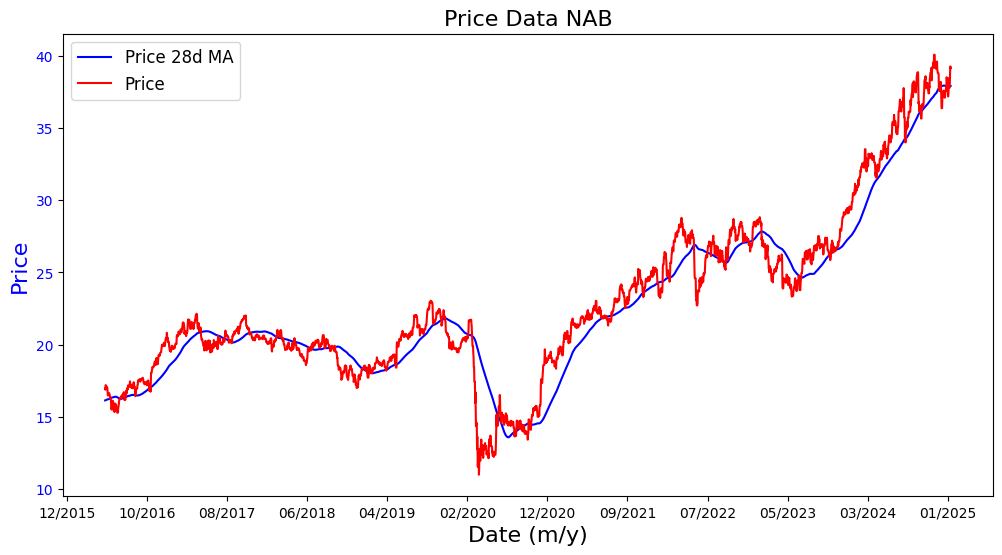

In [22]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the sentiment score on the first y-axis
ax1.plot(stock_data.index, 
         stock_data['close_120_ma'], color='blue', label='Price 28d MA')

ax1.plot(stock_data.index, 
         stock_data['Close'], color='red', label='Price')

ax1.set_xlabel('Date (m/y)', fontsize=16)
ax1.set_ylabel('Price', color='blue', fontsize=16)
ax1.tick_params(axis='y', labelcolor='blue')

# Increase the number of x-axis ticks
ax1.xaxis.set_major_locator(plt.MaxNLocator(12))
ax1.xaxis.set_major_formatter(DateFormatter('%m/%Y'))

ax1.legend(loc='upper left', fontsize=12)

_ = plt.title('Price Data ' + stock_code.upper(), fontsize=16)

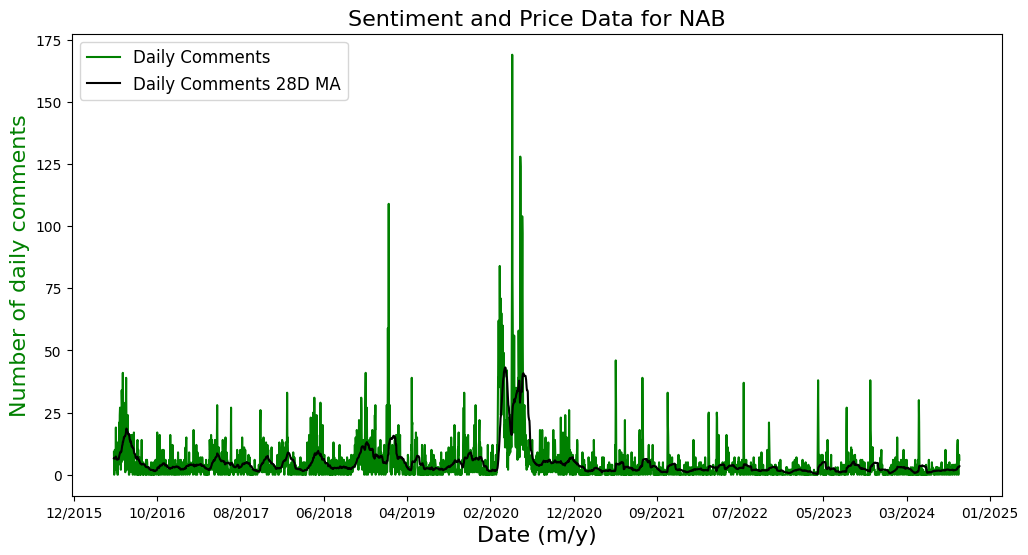

In [23]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot positive and neutral sentiment on the first y-axis
ax1.plot(df_after_specific_date.index, 
         df_after_specific_date['entry_count'], color='green', label='Daily Comments')

ax1.plot(df_after_specific_date.index, 
         df_after_specific_date['entry_count_ma'], color='k', label='Daily Comments 28D MA')

ax1.set_ylabel('Number of daily comments', color='green', fontsize=16)
ax1.tick_params(axis='y', labelcolor='green')

ax1.set_xlabel('Date (m/y)', fontsize=16)
ax1.tick_params(axis='y', labelcolor='black')

# Increase the number of x-axis ticks
ax1.xaxis.set_major_locator(plt.MaxNLocator(12))
ax1.xaxis.set_major_formatter(DateFormatter('%m/%Y'))

# Add legend
ax1.legend(loc='upper left', fontsize=12)

_ = plt.title('Sentiment and Price Data for ' + stock_code.upper(), fontsize=16)